<a href="https://colab.research.google.com/github/jamagiwa/Kaggle/blob/Explore_und_practice/GBM_scRNAseq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#GBM scRNAseqデータを用いてEDAの練習する

What: scRNAseqデータを用いて解析の手法を学ぶ

---

Why: 遺伝子発現、epigenome、proteomeデータを自由に扱えるようになりたいため

---

Result


##データの読み込み、データフレームを作成

使うライブラリ

In [35]:
import kagglehub
import scipy.io
import pandas as pd
import anndata as ad
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
#データのダウンロード
!pip install kagglehub


# Download latest version
path = kagglehub.dataset_download("reminho/human-glioblastoma-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/human-glioblastoma-dataset


In [2]:
#ファイル名の確認
import os
print(os.listdir(path))

['barcodes.tsv', 'matrix.mtx', 'genes.tsv']


barcodes.tsv...各細胞のID, matrix.mtx...実際の遺伝子発現data(ほとんどのgeneが0なので特殊な形式で効率よく保存している。), genes.tsv...遺伝子名のリスト

3つのファイルを読み込む

In [23]:
#ファイルパスを設定
path = "/kaggle/input/human-glioblastoma-dataset"
barcodes_file = f"{path}/barcodes.tsv"
gene_file = f"{path}/genes.tsv"
matrix_file = f"{path}/matrix.mtx"

##QC, ノイズ除去

In [7]:
#Colaboにanndataをダウンロード
!pip install anndata scanpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.9/169.9 kB 942.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 4.5 MB/s eta 0:00:00


In [51]:
# matrix/mtxを読み込む
# mmreadはcoo_matrix形式で読み込むため、転置してCSR形式に変換する
matrix = scipy.io.mmread(matrix_file).T.tocsr()

# obs (細胞) DataFrameの作成
barcodes_df = pd.DataFrame(pd.read_csv(barcodes_file, header=None).iloc[:, 0]) #barcodes_fileを読み込みヘッダーがないためNone.０列目の全てのデータを読み込む
barcodes_df.columns = ['cell_barcode']#抽出した列にcell_barcodesと名前をつける

# var (遺伝子) DataFrameの作成
genes_df = pd.DataFrame(pd.read_csv(gene_file, header=None).iloc[:, 0])
genes_df.columns = ['gene_name']

# AnnDataオブジェクトの作成
adata = ad.AnnData(
    X = matrix,
    obs = barcodes_df,
    var = genes_df
)

# 作成したAnnDataオブジェクトの確認
print(adata)

AnnData object with n_obs × n_vars = 5697 × 1186
    obs: 'cell_barcode'
    var: 'gene_name'


/usr/lib/python3.12/functools.py:912: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/usr/lib/python3.12/functools.py:912: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


##フィルタリングを行う

---
どの遺伝子を残すか、フィルターをかける


In [69]:
print(adata_fil[])

AnnData object with n_obs × n_vars = 4433 × 1140
    obs: 'cell_barcode', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_MT', 'pct_counts_MT'
    var: 'gene_name', 'n_cells', 'MT', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'


In [82]:
#anndataのコピーを作成、元データの保護
adata_fil = adata.copy()

#遺伝子のフィルタリング
#少なくとも3つの細胞で発現している遺伝子を残す
#pp...pre-processing
sc.pp.filter_genes(adata_fil, min_cells=3)

#少なくとも200の細胞で発現している遺伝子を残す
sc.pp.filter_cells(adata_fil, min_genes=200)

print(f"元の細胞数{adata.n_obs}, 遺伝子数{adata.n_vars}")
print(f"フィルタリング後の細胞数{adata_fil.n_obs}, 遺伝子数{adata_fil.n_vars}")

元の細胞数5697, 遺伝子数1186
フィルタリング後の細胞数4433, 遺伝子数1140


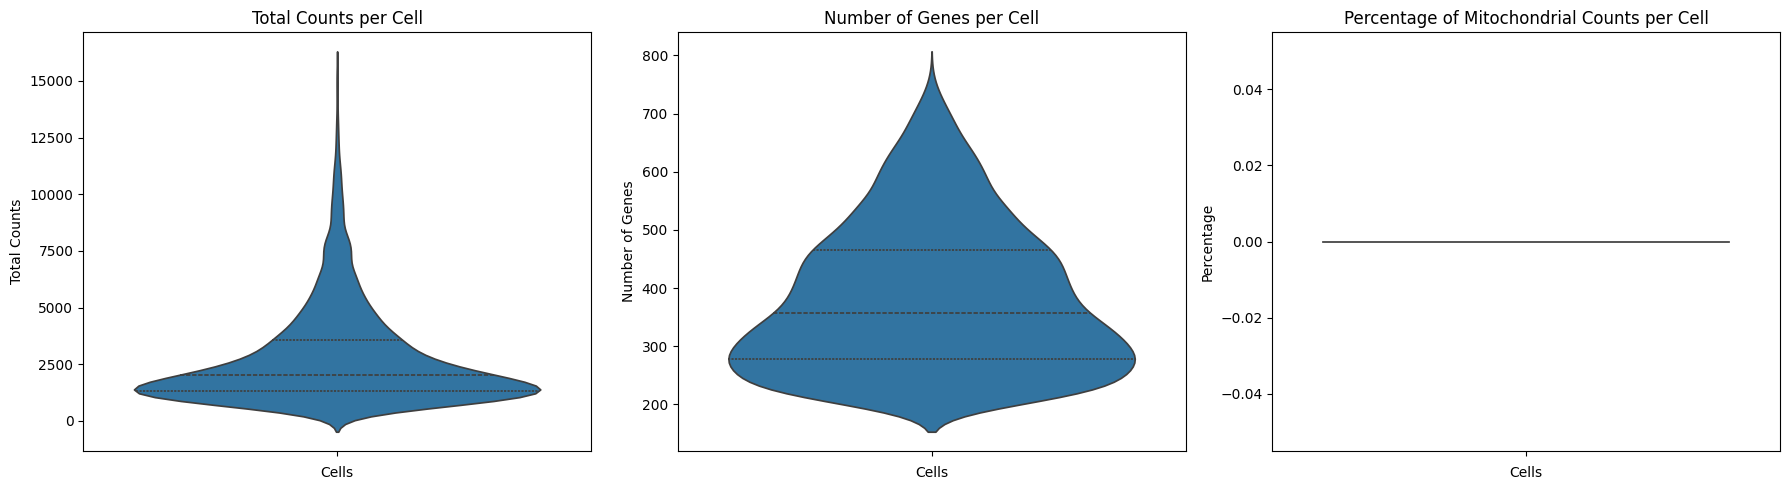

In [79]:
#ミトコンドリア遺伝子を識別する
#"MT"で始まる遺伝子を探す
adata_fil.var['MT'] = adata_fil.var["gene_name"].str.startswith("MT-")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# QCメトリクスを計算
sc.pp.calculate_qc_metrics(adata_fil, qc_vars=['MT'], percent_top=None, log1p=False, inplace=True)

# バイオリンプロット1: 総読取数
sns.violinplot(y='total_counts', data=adata_fil.obs, ax=axes[0], inner='quartile')
axes[0].set_title('Total Counts per Cell')
axes[0].set_xlabel('Cells')
axes[0].set_ylabel('Total Counts')

# バイオリンプロット2: 発現遺伝子数
sns.violinplot(y='n_genes_by_counts', data=adata_fil.obs, ax=axes[1], inner='quartile')
axes[1].set_title('Number of Genes per Cell')
axes[1].set_xlabel('Cells')
axes[1].set_ylabel('Number of Genes')

# バイオリンプロット3: ミトコンドリア遺伝子の割合
sns.violinplot(y='pct_counts_MT', data=adata_fil.obs, ax=axes[2], inner='quartile')
axes[2].set_title('Percentage of Mitochondrial Counts per Cell')
axes[2].set_xlabel('Cells')
axes[2].set_ylabel('Percentage')

plt.tight_layout()
plt.show()

In [84]:
print(adata.var.columns)

Index(['gene_name'], dtype='object')
